# In this notebook we analyze the results from first_pass.jl of rho(epsilon)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from typing import Dict

sns.set_theme(style="darkgrid", palette="deep")

In [4]:
# Data params

# L_vals = [8000, 10_000, 12_000, 14_000, 16_000, 18_000, 20_000]
L_vals = [800, 8000, 10000, 12_000, 16_000]
epsilon_vals = sorted(set([round(0.001 * i, ndigits=4) for i in range(0, 350)] + [round(0.291 + 0.0001 * i, ndigits=4) for i in range(0, 60+1)]))

time_prefact = 200

num_initial_conds = 500
initial_state_prob = 0.5



In [5]:

avrage_rho_per_ep : Dict[int, Dict[float, float]] = {}
sem_rho_per_ep : Dict[int, Dict[float, float]] = {}

for L_val in L_vals:
    avrage_rho_per_ep[L_val] = {}
    sem_rho_per_ep[L_val] = {}
    for epsilon_val in epsilon_vals:

        sample_filepath = f"data/rho_per_epsilon/IC1/L{L_val}/IC1_L{L_val}_epsilon{str(epsilon_val).replace("0.", "0p")}.csv"
        
        sample_df = pd.read_csv(sample_filepath)

        avrage_rho_per_ep[L_val][epsilon_val] = sample_df["rho"].mean()
        sem_rho_per_ep[L_val][epsilon_val] = sample_df["rho"].sem()
        

In [6]:
avrage_rho_per_ep[8000].keys()

dict_keys([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08, 0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09, 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1, 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108, 0.109, 0.11, 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117, 0.118, 0.119, 0.12, 0.121, 0.122, 0.123, 0.124, 0.125, 0.126, 0.127, 0.128, 0.129, 0.13, 0.131, 0.132, 0.133, 0.134, 0.135, 0.136, 0.137, 0.138, 0.139, 0.14, 0.141, 0.142, 0.143

# Basic plot of 1-rho per epsilon

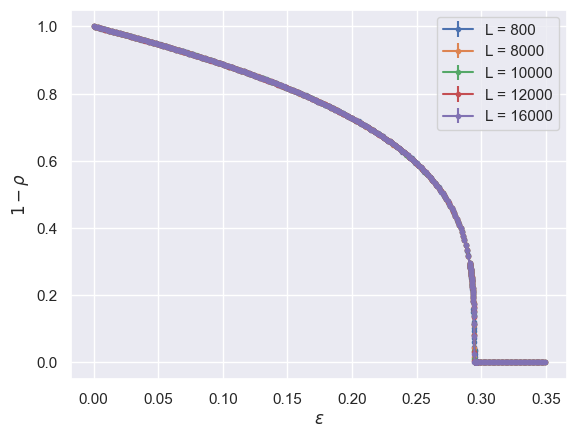

In [7]:

for L in L_vals:
    epsilon_vals = sorted(list(avrage_rho_per_ep[L].keys()))
    plt.errorbar(
        epsilon_vals, 
        [1-avrage_rho_per_ep[L][epsilon_val] for epsilon_val in epsilon_vals], 
        yerr=[sem_rho_per_ep[L][epsilon_val] for epsilon_val in epsilon_vals],
        label = f"L = {L}",
        fmt='-o',  
        markersize=3
        )

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$1 - \rho$")
plt.legend()
plt.show()


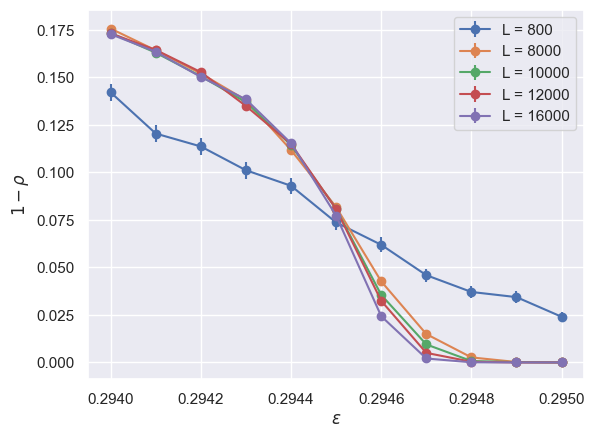

In [8]:
trans_window = (0.294, 0.295)

for L in L_vals:
    epsilon_vals = sorted([epsilon for epsilon in avrage_rho_per_ep[L].keys() if trans_window[0] <= epsilon <= trans_window[1]])
    plt.errorbar(
        epsilon_vals, 
        [1-avrage_rho_per_ep[L][epsilon_val] for epsilon_val in epsilon_vals], 
        yerr=[sem_rho_per_ep[L][epsilon_val] for epsilon_val in epsilon_vals],
        label = f"L = {L}",
        fmt='-o',  
        # markersize=2
        )

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$1 - \rho$")
plt.legend()
plt.show()
